In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch

In this homework we consider the Lotka-Volterra ODE systems

$$\frac{d}{dt} {p}_{prey} = \alpha p_{prey} - \beta p_{prey} p_{predator}$$

$$\frac{d}{dt} {p}_{predator} = - \gamma p_{predator} + \delta p_{prey} p_{predator}$$

Here $\alpha, \beta, \gamma, \delta > 0$ are the parameters of the model.

In [3]:
def lotka_volterra(p, t, alpha, beta, delta, gamma):
    # Define the RHS of LV model
    # input parameters: alpha, beta, gamma, delta
    # p: state of the system, array of size 2
    # t: time, scalar
    # output: d/dt p
    prey, predator = p
    dprey_dt = alpha * prey - beta * prey * predator
    dpredator_dt = delta * prey * predator - gamma * predator
    return [dprey_dt, dpredator_dt]

The following code simulates the LV model for parameters $(\alpha, \beta, \gamma, \delta) = (1, 0.1, 0.075, 1.5]$ over the interval $[0, 20]$.

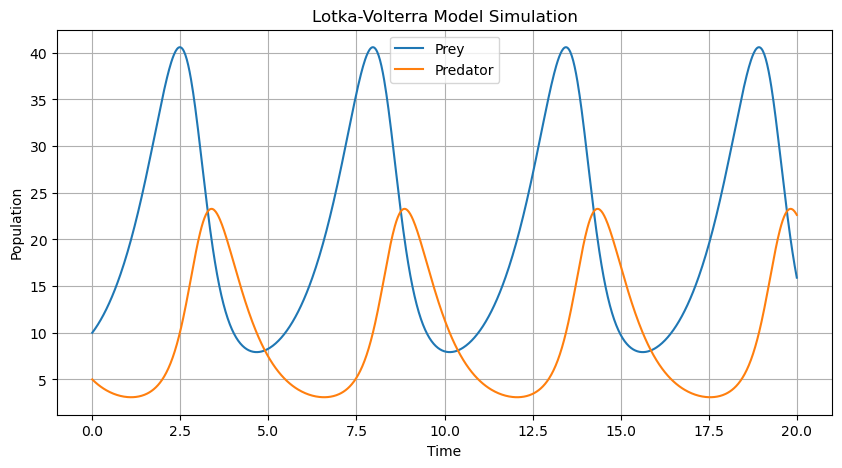

In [4]:
def simulate_lotka_volterra(
    alpha=1.0,
    beta=0.1,
    delta=0.075,
    gamma=1.5,
    p0=(10, 5),
    T=20,
    num_points=1000
):
    """
    Simulates the Lotka-Volterra system.

    Parameters:
    alpha, beta, delta, gamma : float
        Parameters of the Lotka-Volterra model.
    p0 : tuple
        Initial conditions (prey, predator).
    T : float
        Total simulation time.
    num_points : int
        Number of points in the time grid.

    Returns:
    t : ndarray
        Time points.
    sol : ndarray
        Solution array (prey, predator).
    """
    t = np.linspace(0, T, num_points)
    sol = odeint(lotka_volterra, p0, t, args=(alpha, beta, delta, gamma))
    return t, sol

# Set parameters
alpha = 1.0   # Prey birth rate
beta = 0.1    # Predation rate
delta = 0.075 # Predator reproduction rate
gamma = 1.5   # Predator death rate

# Initial population
p0 = (10, 5)

# Simulation settings
T = 20            # Total time
num_points = 1000 # Number of time points

# Run simulation
t, sol = simulate_lotka_volterra(alpha, beta, delta, gamma, p0, T, num_points)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(t, sol[:, 0], label='Prey')
plt.plot(t, sol[:, 1], label='Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Lotka-Volterra Model Simulation')
plt.legend()
plt.grid(True)
plt.show()

We assume that we will not see the entire trajectory of the system, but rather observe the predator and prey populations at a limited number of observation points in time. In the following code the 'dt_obs' parameter denotes the time interval between two observations.

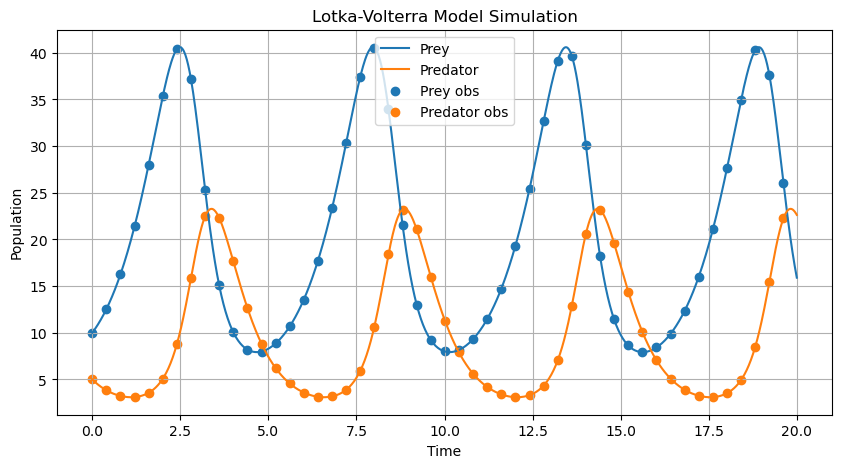

In [5]:
delta_t_obs = 0.4

skip = int(np.rint(delta_t_obs*num_points/T))

# Func
y = sol[0::skip]
ty = t[0::skip]

# Plot results
plt.figure(figsize=(10,5))

plt.plot(t, sol[:, 0], label='Prey')
plt.plot(t, sol[:, 1], label='Predator')

plt.scatter(ty, y[:, 0], label='Prey obs')
plt.scatter(ty, y[:, 1], label='Predator obs')

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Lotka-Volterra Model Simulation')
plt.legend()
plt.grid(True)
plt.show()

Your goal in this homework is to learn the right hand side of the LV system from the limited data $(t_n, y_n)_{n=0}^N$ where
$$ t_n = \frac{T}{\delta t_{obs}}i \quad \text{and} \quad  
y_n = \big(p_{prey}(t_n), p_{predator}(t_n) \big).$$
You will do this in three steps:

Step 1) Given the above data, use kernel ridge regression to approximate the prey and predator trajectories as functions of time, i.e.,
$$ \hat{p}_{prey}(t) \approx p_{prey}(t),
\qquad \text{and} \qquad
\hat{p}_{predator}(t) \approx p_{predator}(t)$$
for $t \in [0, T]$.  

In [194]:
# Convert torch tensor to numpy array.
def to_numpy(A):
    return A.clone().detach().cpu().numpy()

# Turn data into a torch tensor.
def tensorfy(A, dtype=torch.float32):
    if isinstance(A, torch.Tensor):
        return A.clone().detach().to(dtype=dtype, device='cuda')
    return torch.tensor(A, dtype=dtype, device='cuda')
    
# Make an RBF kernel.
def rbf_kernel(A, B, l):
    # Ensure A and B are at least 2D column vectors.
    if A.ndim == 1:
        A = A[:, None]  # Shape (m, 1)
    if B.ndim == 1:
        B = B[:, None]  # Shape (p, 1)

    # Compute squared norms.
    A_norm = (A ** 2).sum(dim=1, keepdim=True)
    B_norm = (B ** 2).sum(dim=1, keepdim=True).T  

    # Pairwise squared Euclidean distances.
    cross_term = A @ B.T # Shape (m, p)
    dists_squared = A_norm + B_norm - 2 * cross_term  # Shape (m, p)
    dists_squared = torch.clamp(dists_squared, min=0.0)  # Avoid negative dists.

    return torch.exp(-dists_squared / l)

def laplacian_kernel(A, B, l):
    # Ensure A and B are 2D tensors
    if A.ndim == 1:
        A = A[:, None]  # Shape (m, 1)
    if B.ndim == 1:
        B = B[:, None]  # Shape (n, 1)

    # Compute pairwise L1 distances
    # A: (m, d), B: (n, d)
    # Compute |A_i - B_j| for all i, j
    m, d = A.shape
    n = B.shape[0]
    A_expanded = A.unsqueeze(1).expand(m, n, d)
    B_expanded = B.unsqueeze(0).expand(m, n, d)
    dists = torch.abs(A_expanded - B_expanded).sum(dim=2)  # Shape: (m, n)

    # Compute the Laplacian kernel matrix.
    return torch.exp(-dists / l)

def tanh_kernel(A, B, l=0):
   return torch.tanh(A @ B.t())

# Make a polynomial kernel.
def poly_kernel(A, B, l=0):
    return (l + A @ B.t()) ** 2
    
# Return the fittted classification function.
def kernel_model_func(X, Y, l, gamma, kernel_func):
    # Make kernel matrix from training data.
    K = kernel_func(A=X, B=X, l=l)
    B = torch.linalg.solve(K + gamma * torch.eye(K.shape[0], device='cuda'), Y)
    # Define trained classifier.
    def func(x_in):
        return kernel_func(A=x_in, B=X, l=l) @ B
    return func

# Estimate the derivatives with the representer formula.
# Assume the RBF kernel.
def est_deriv_kernel(t_train, t_test, f, l, gamma=0.1):
    # Get K.
    K = rbf_kernel(t_train, t_test, l)
    # Get derivative estimate.
    dK = (1 / l) * (t_train[:, None] - t_test[None, :]) * K
    df = f.t() @ dK
    return df

def est_deriv_prey(y_prey, y_pred, alpha=1, beta=0.1):
    return alpha * y_prey - beta * y_prey * y_pred 

def est_deriv_pred(y_prey, y_pred, g=1.5, delta=0.075):
    return -g * y_pred + delta * y_prey * y_pred 

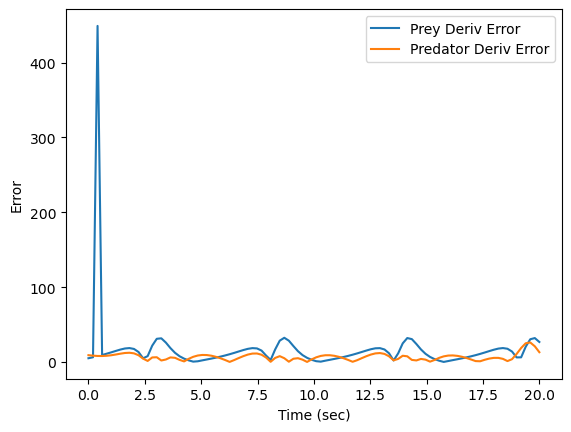

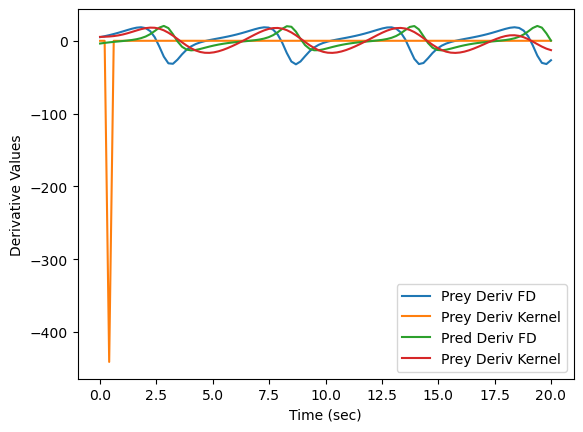

In [208]:
# Define params.
l_prey = 0.0000041
gamma_prey = 0.4

l_pred = 2
gamma_pred = 0.1

# Turn data into torch tensors.
# time (input data - X)
ty = tensorfy(ty)
# function data (Y)
y = tensorfy(y)

# Split y.
y_prey = y[:, 0]
y_pred = y[:, 1]

# Make trained models for prey and predator.
model_prey = kernel_model_func(ty, y_prey, l_prey, gamma_prey, rbf_kernel)
model_pred = kernel_model_func(ty, y_pred, l_pred, gamma_pred, rbf_kernel)

# Get feature estimators.
hat_prey_feature = model_prey(ty)
hat_predator_feature = model_pred(ty)

# Plot error.
error_prey = torch.abs(y_prey - hat_prey_feature)
error_pred = torch.abs(y_pred - hat_predator_feature)

# # Plot.
# fig, ax = plt.subplots()
# plt.xlabel("Time (sec)")
# plt.ylabel("Error")
# plt.plot(to_numpy(ty), to_numpy(error_prey), label="Prey")
# plt.plot(to_numpy(ty), to_numpy(error_pred), label="Predator")
# plt.legend()
# plt.show()

# Make denser grid.
t_dense = tensorfy(np.linspace(0, 20, 100))

# Kernel derivative estimates.
dt_hat_prey = est_deriv_kernel(t_train=ty, t_test=t_dense, f=y_prey, l=l_prey, gamma=gamma_prey)
dt_hat_predator = est_deriv_kernel(t_train=ty, t_test=t_dense, f=y_pred, l=l_pred, gamma=gamma_pred)

# Get true values.
y_prey_dense = tensorfy(sol[:, 0][0::10])
y_pred_dense = tensorfy(sol[:, 1][0::10])

# Compute derivatives based on definiton.
dt_hat_prey_fd = est_deriv_prey(y_prey=y_prey_dense, y_pred=y_pred_dense)
dt_hat_predator_fd = est_deriv_pred(y_prey=y_prey_dense, y_pred=y_pred_dense)

# Computer derivative errors.
d_error_prey = torch.abs(dt_hat_prey_fd - dt_hat_prey)
d_error_pred = torch.abs(dt_hat_predator_fd - dt_hat_predator)

# Plots Part 2.
fig, ax = plt.subplots()
plt.xlabel("Time (sec)")
plt.ylabel("Error")
plt.plot(to_numpy(t_dense), to_numpy(d_error_prey), label="Prey Deriv Error")
plt.plot(to_numpy(t_dense), to_numpy(d_error_pred), label="Predator Deriv Error")
plt.legend()
plt.show()

fig, ax = plt.subplots()
plt.xlabel("Time (sec)")
plt.ylabel("Derivative Values")
plt.plot(to_numpy(t_dense), to_numpy(dt_hat_prey_fd), label="Prey Deriv FD")
plt.plot(to_numpy(t_dense), to_numpy(dt_hat_prey), label="Prey Deriv Kernel")
plt.plot(to_numpy(t_dense), to_numpy(dt_hat_predator_fd), label="Pred Deriv FD")
plt.plot(to_numpy(t_dense), to_numpy(dt_hat_predator), label="Prey Deriv Kernel")
plt.legend()
plt.show()

Step 3) Observing that the LV system is of the generic form

$$
\frac{d}{dt} p_{prey} = f_{prey}( p_{prey}, p_{predator} ) \\
\frac{d}{dt} p_{predator} = f_{predator}( p_{prey}, p_{predator} )
$$

Use your estimated values for $\hat{p}_{prey}, \hat{p}_{predator}, \frac{d}{dt}\hat{p}_{prey}, \frac{d}{dt} \hat{p}_{predator}$ at $(t_i)_{i=1}^N$ to formulate a second kernel ridge regression problem for the functions $\hat f_{prey} \approx f_{prey}$ and $\hat f_{predator} \approx f_{predator}$.

In [210]:
# Make training data.
X_train = torch.stack((y_prey_dense, y_pred_dense), dim=1) 
y_train = torch.stack((dt_hat_prey, dt_hat_predator), dim=1)

# Make plotting domain.
m, n = 600, 60
shape = (m, n)
prey_vals = np.linspace(0, 600, m)
pred_vals = np.linspace(0, 60, n)
P1, P2 = np.meshgrid(prey_vals, pred_vals)
P1 = tensorfy(P1)
P2 = tensorfy(P2)
grid_points = torch.stack([P1.ravel(), P2.ravel()], dim=1)  
f_prey_true = est_deriv_prey(P1.ravel(), P2.ravel()).reshape(shape)
f_pred_true = est_deriv_pred(P1.ravel(), P2.ravel()).reshape(shape)

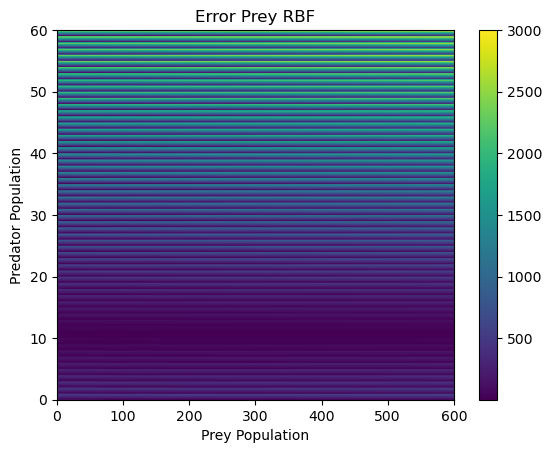

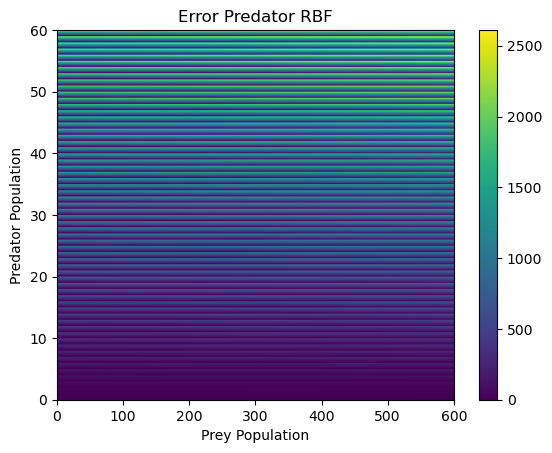

In [215]:
# Train a model with RBF.
l_rbf = 100
gamma_rbf = 0.01
model_rbf = kernel_model_func(X_train, y_train, l_rbf, gamma_rbf, rbf_kernel)
f_rbf = model_rbf(grid_points)
f_prey_rbf = f_rbf[:, 0].reshape(shape)
f_pred_rbf = f_rbf[:, 1].reshape(shape)
error_prey_rbf = torch.abs(f_prey_rbf - f_prey_true)
error_pred_rbf = torch.abs(f_pred_rbf - f_pred_true)

# Plot.
plt.title("Error Prey RBF")
plt.imshow(to_numpy(error_prey_rbf), extent=[0, 600, 0, 60], origin='lower', aspect='auto')
plt.xlabel("Prey Population")
plt.ylabel("Predator Population")
plt.colorbar()
plt.show()

plt.title("Error Predator RBF")
plt.imshow(to_numpy(error_pred_rbf), extent=[0, 600, 0, 60], origin='lower', aspect='auto')
plt.xlabel("Prey Population")
plt.ylabel("Predator Population")
plt.colorbar()
plt.show()

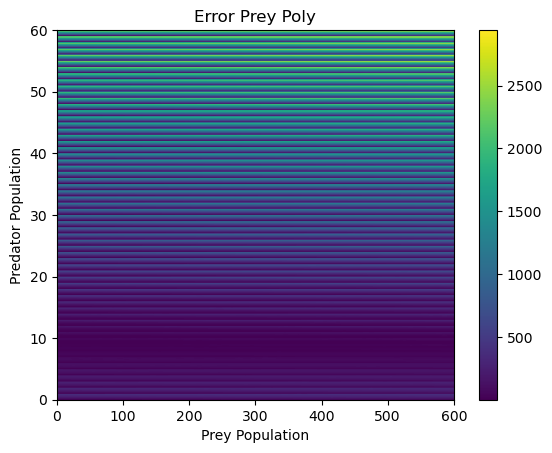

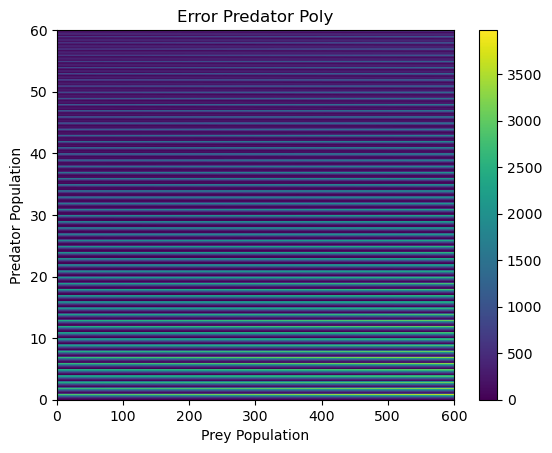

In [225]:
# Train a model with poly.
l_poly = 0.001
gamma_poly = 1000
model_poly = kernel_model_func(X_train, y_train, l_poly, gamma_poly, poly_kernel) 
f_poly = model_poly(grid_points)
f_prey_poly = f_poly[:, 0].reshape(shape)
f_pred_poly = f_poly[:, 1].reshape(shape)
error_prey_poly = torch.abs(f_prey_poly - f_prey_true)
error_pred_poly = torch.abs(f_pred_poly - f_pred_true)

# Plot.
plt.title("Error Prey Poly")
plt.imshow(to_numpy(error_prey_poly), extent=[0, 600, 0, 60], origin='lower', aspect='auto')
plt.xlabel("Prey Population")
plt.ylabel("Predator Population")
plt.colorbar()
plt.show()

plt.title("Error Predator Poly")
plt.imshow(to_numpy(error_pred_poly), extent=[0, 600, 0, 60], origin='lower', aspect='auto')
plt.xlabel("Prey Population")
plt.ylabel("Predator Population")
plt.colorbar()
plt.show()

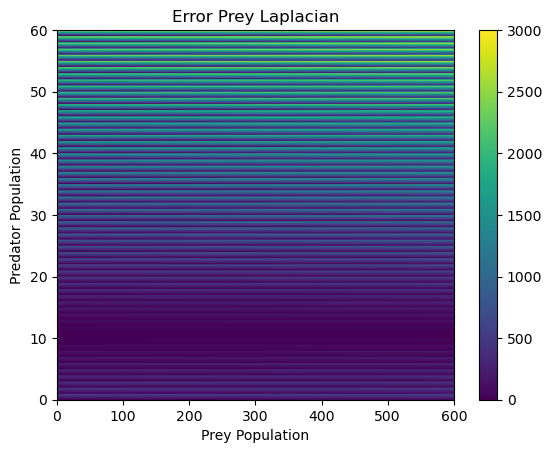

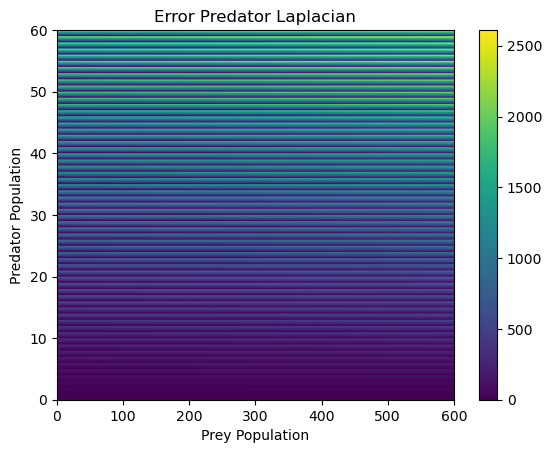

In [234]:
# Train a model with Laplacian.
l_lap = 0.11
gamma_lap = 50
model_lap = kernel_model_func(X_train, y_train, l_lap, gamma_lap, laplacian_kernel)
f_lap = model_lap(grid_points)
f_prey_lap = f_lap[:, 0].reshape(shape)
f_pred_lap = f_lap[:, 1].reshape(shape)
error_prey_lap = torch.abs(f_prey_lap - f_prey_true)
error_pred_lap = torch.abs(f_pred_lap - f_pred_true)

# Plot.
plt.title("Error Prey Laplacian")
plt.imshow(to_numpy(error_prey_lap), extent=[0, 600, 0, 60], origin='lower', aspect='auto')
plt.xlabel("Prey Population")
plt.ylabel("Predator Population")
plt.colorbar()
plt.show()

plt.title("Error Predator Laplacian")
plt.imshow(to_numpy(error_pred_lap), extent=[0, 600, 0, 60], origin='lower', aspect='auto')
plt.xlabel("Prey Population")
plt.ylabel("Predator Population")
plt.colorbar()
plt.show()